In [14]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np
import random
import copy

## CODIFICACION

$${(f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,f12,r1,r2,r3,r4,r5,r6,r7,r8,r9,r10,r11,r12)}$$

12 𝗑 2 = 24 enteros.

12 Orden y 12 de rotacion.

Las f:
* Toman valores reales.

Las r van de 0 a 7:
* De 0 a 3 giro pieza normal.
* De 4 a 7 giro de pieza invertida.

Al decodificar se barre de izquierda a derecha y de arriba a abajo seleccionando la ficha en el orden de las f. Si no puede colocar la ficha, pasa a la siguiente y asi hasta llegar al final de la cola (f). Si no se puede deja hueco en blanco y pasa al siguiente (tambien vuelve a la cabeza de la cola de las figuras).


### Parametros y definiciones globales

In [15]:
PENTOMINOS_BASE = {
    'F': [(1,0), (1,1), (1,2), (0,1), (2,2)], #0
    'I': [(0,0), (0,1), (0,2), (0,3), (0,4)], #1
    'L': [(0,0), (1,0), (2,0), (3,0), (3,1)], #2
    'P': [(0,0), (0,1), (1,0), (1,1), (2,0)], #3
    'N': [(0,1), (1,1), (2,1), (2,0), (3,0)], #4
    'T': [(0,0), (0,1), (0,2), (1,1), (2,1)], #5
    'U': [(0,0), (0,2), (1,0), (1,1), (1,2)], #6
    'V': [(0,0), (1,0), (2,0), (2,1), (2,2)], #7
    'W': [(0,0), (1,0), (1,1), (2,1), (2,2)], #8
    'X': [(1,0), (0,1), (1,1), (2,1), (1,2)], #9
    'Y': [(0,1), (1,0), (1,1), (1,2), (1,3)], #10
    'Z': [(0,0), (0,1), (1,1), (2,1), (2,2)]  #11
}
PIECE_ORDER = list(PENTOMINOS_BASE.keys())

def generar_variantes(coords):
    variantes = []
    def normalizar(c):
        min_y = min(p[0] for p in c)
        min_x = min(p[1] for p in c)
        return [(y - min_y, x - min_x) for y, x in c]

    actual = coords
    for _ in range(4):
        variantes.append(normalizar(actual))
        actual = [(x, -y) for y, x in actual]
    espejo = [(-y, x) for y, x in coords]
    actual = espejo
    for _ in range(4):
        variantes.append(normalizar(actual))
        actual = [(x, -y) for y, x in actual]
    return variantes


### Precalcular todas las posibles rotaciones de cada ficha para no hacer tantos calculos por individuo

In [16]:
TODAS_LAS_FORMAS = []
for k in PIECE_ORDER:
    TODAS_LAS_FORMAS.append(generar_variantes(PENTOMINOS_BASE[k]))

### Reglas del juego (motor geometrico)

In [17]:
def cabe(grid, x_origen, y_origen, forma, alto, ancho):
    for dy, dx in forma:
        ny, nx = y_origen + dy, x_origen + dx
        if ny < 0 or ny >= alto or nx < 0 or nx >= ancho:
            return False
        if grid[ny][nx] != -1:
            return False
    return True

def poner(grid, x_origen, y_origen, forma, id_val):
    for dy, dx in forma:
        grid[y_origen + dy][x_origen + dx] = id_val

def decodificador_completo(cromosoma_orden, cromosoma_rotacion, alto, ancho):
    """
    Lógica de 'Barrido con saltos' encapsulada aquí.
    Devuelve: (grid, piezas_colocadas, huecos_totales)
    """
    grid = np.full((alto, ancho), -1)
    disponibles = []
    for i in range(12):
        disponibles.append({'id': cromosoma_orden[i], 'rot': cromosoma_rotacion[i]})

    piezas_colocadas = 0

    for y in range(alto):
        for x in range(ancho):
            if not disponibles: break
            if grid[y][x] != -1: continue

            # Estamos en un hueco vacío
            pieza_insertada = False
            indice_eliminar = -1

            for i, pieza in enumerate(disponibles):
                forma = TODAS_LAS_FORMAS[pieza['id']][pieza['rot']]
                encaja = False
                for by, bx in forma:
                    ay, ax = y - by, x - bx
                    if cabe(grid, ax, ay, forma, alto, ancho):
                        poner(grid, ax, ay, forma, pieza['id'])
                        encaja = True
                        break
                if encaja:
                    pieza_insertada = True
                    indice_eliminar = i
                    piezas_colocadas += 1
                    break

            if pieza_insertada:
                disponibles.pop(indice_eliminar)
            else:
                pass # Saltamos el hueco

    # Contar huecos vacíos (-1)
    huecos = np.sum(grid == -1)
    return grid, piezas_colocadas, huecos

### Clase de Individuo (posible solucion)

In [18]:
class Individuo:
    def __init__(self, orden=None, rotaciones=None):
        """
        Si se pasan argumentos, se crea un hijo específico.
        Si son None, se crea un individuo aleatorio.
        """
        if orden is None:
            # Generate random float values for the order, to be ranked later
            self.orden = [random.random() for _ in range(12)]
        else:
            self.orden = orden

        if rotaciones is None:
            self.rotaciones = [random.randint(0, 7) for _ in range(12)]
        else:
            self.rotaciones = rotaciones

        # Propiedades del Fenotipo (se calculan al evaluar)
        self.fitness = 0
        self.tablero = None
        self.piezas_colocadas = 0
        self.huecos = 0

    def evaluar(self, alto, ancho):
        """
        Ejecuta el decodificador y calcula el Fitness.
        Con la nueva lógica, 'self.orden' son valores que se rankean
        para determinar la secuencia de piezas (0 a 11).
        """
        # Crear una lista de tuplas (indice_original, valor_orden)
        indexed_order_values = list(enumerate(self.orden))

        # Ordenar por el valor del gen (valor_orden) en orden ascendente.
        # El valor más bajo corresponderá a la pieza 'F' (ID 0), el más alto a 'Z' (ID 11).
        indexed_order_values.sort(key=lambda x: x[1])

        # Construir el cromosoma_orden real (lista de IDs de pieza)
        # La posición en esta lista corresponde al índice original, y el valor es el ID de la pieza.
        cromosoma_orden_piezas = [0] * 12
        for rank, (original_index, _) in enumerate(indexed_order_values):
            cromosoma_orden_piezas[original_index] = rank # rank will go from 0 to 11

        self.tablero, self.piezas_colocadas, self.huecos = decodificador_completo(
            cromosoma_orden_piezas, self.rotaciones, alto, ancho
        )

        # --- FUNCIÓN DE FITNESS ---
        # 1. Premiar mucho poner piezas (base)
        score = self.piezas_colocadas * 100

        # 2. Penalizar huecos (opcional, ayuda a desempatar)
        # Menos huecos = mejor
        score -= self.huecos * 5

        self.fitness = score

    def mutar(self, tasa_mutacion=0.1):
        """
        Aplica cambios aleatorios al genoma.
        """
        pass

    def copiar(self):
        """ Crea una copia profunda para no alterar referencias """
        nuevo = Individuo(self.orden[:], self.rotaciones[:])
        nuevo.fitness = self.fitness
        # No copiamos el tablero para ahorrar memoria hasta que se evalúe
        return nuevo

### Visualizador


In [19]:
def mostrar_individuo(ind):
    if ind.tablero is None:
        print("El individuo no ha sido evaluado.")
        return

    matriz = np.array(ind.tablero)
    alto_m, ancho_m = matriz.shape

    cmap_base = plt.cm.tab20
    colores = ["whitesmoke"] + [cmap_base(i) for i in range(12)]
    cmap = mcolors.ListedColormap(colores)
    bounds = np.arange(-1.5, 12.5, 1)
    norm = mcolors.BoundaryNorm(bounds, cmap.N)

    fig, ax = plt.subplots(figsize=(6, 4))
    ax.imshow(matriz, origin='upper', cmap=cmap, norm=norm)
    ax.set_aspect('equal')

    ax.set_xticks(np.arange(ancho_m) - 0.5, minor=True)
    ax.set_yticks(np.arange(alto_m) - 0.5, minor=True)
    ax.grid(which="minor", color="black", linestyle="-", linewidth=1)
    ax.tick_params(which="minor", bottom=False, left=False)
    ax.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)

    for y in range(alto_m):
        for x in range(ancho_m):
            idx = matriz[y][x]
            if idx >= 0:
                ax.text(x, y, PIECE_ORDER[idx], ha="center", va="center", fontweight='bold')

    plt.title(f"Fitness: {ind.fitness} | Piezas: {ind.piezas_colocadas}")
    plt.tight_layout()
    plt.show()

### PRUEBAS DE INICIALIZACION DE POBLACION

Generando población de 100 individuos

--- Resultados Generación 0 ---
Mejor Fitness: 950 (Piezas: 10)
Peor Fitness:  575
Mejor Genoma: [0.24284873627708037, 0.46984818811599405, 0.33031270652695643, 0.897541169357574, 0.49073799008485885, 0.8291618918749163, 0.10835271627982668, 0.8364640819029496, 0.1189569550025058, 0.4037628828751989, 0.9490438771751102, 0.4513150314747759] [6, 2, 0, 6, 7, 5, 0, 3, 0, 6, 3, 5]

MEJOR INDIVIDUO


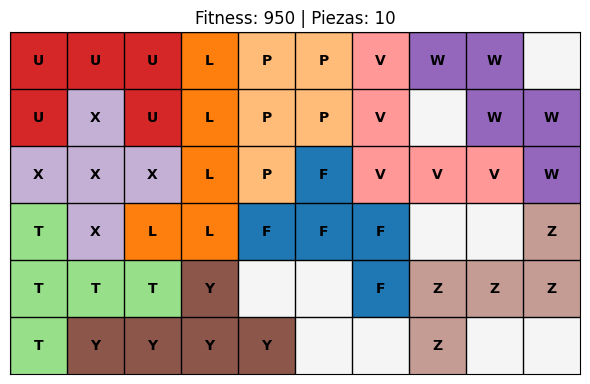


PEOR INDIVIDUO


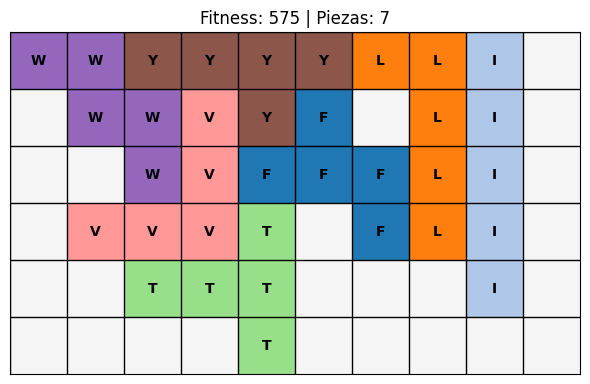

In [20]:
ALTO = 6
ANCHO = 10
TAMANO_POBLACION = 100

print(f"Generando población de {TAMANO_POBLACION} individuos")

# 1. Crear Población
poblacion = [Individuo() for _ in range(TAMANO_POBLACION)]

# 2. Evaluar a todos
for ind in poblacion:
    ind.evaluar(ALTO, ANCHO)

# 3. Ordenar por Fitness (Mayor a menor)
poblacion.sort(key=lambda x: x.fitness, reverse=True)

mejor = poblacion[0]
peor = poblacion[-1]

print(f"\n--- Resultados Generación 0 ---")
print(f"Mejor Fitness: {mejor.fitness} (Piezas: {mejor.piezas_colocadas})")
print(f"Peor Fitness:  {peor.fitness}")

print(f"Mejor Genoma: {mejor.orden} {mejor.rotaciones}")

print("\nMEJOR INDIVIDUO")
mostrar_individuo(mejor)

print("\nPEOR INDIVIDUO")
mostrar_individuo(peor)

### Mostrar figura girada (solo para probar cositas)

In [21]:
def mostrar_pentomino_base(nombre_pieza, rotation_idx=0):
    # Obtener el ID de la pieza para indexar TODAS_LAS_FORMAS
    idx = PIECE_ORDER.index(nombre_pieza)
    # Obtener la forma rotada específica
    forma_rotada = TODAS_LAS_FORMAS[idx][rotation_idx]

    # Calcular dimensiones mínimas de la pieza
    min_y = min(p[0] for p in forma_rotada)
    max_y = max(p[0] for p in forma_rotada)
    min_x = min(p[1] for p in forma_rotada)
    max_x = max(p[1] for p in forma_rotada)

    alto_m = max_y - min_y + 1
    ancho_m = max_x - min_x + 1

    # Crear una matriz pequeña para la pieza
    matriz = np.full((alto_m, ancho_m), -1, dtype=int)

    # Colocar la pieza en la matriz
    for y, x in forma_rotada:
        matriz[y - min_y][x - min_x] = idx

    # Configuración de colores (igual que mostrar_individuo)
    cmap_base = plt.cm.tab20
    colores = ["whitesmoke"] + [cmap_base(i) for i in range(12)]
    cmap = mcolors.ListedColormap(colores)
    bounds = np.arange(-1.5, 12.5, 1)
    norm = mcolors.BoundaryNorm(bounds, cmap.N)

    fig, ax = plt.subplots(figsize=(ancho_m * 0.8, alto_m * 0.8))
    ax.imshow(matriz, origin='upper', cmap=cmap, norm=norm)
    ax.set_aspect('equal')

    ax.set_xticks(np.arange(ancho_m) - 0.5, minor=True)
    ax.set_yticks(np.arange(alto_m) - 0.5, minor=True)
    ax.grid(which="minor", color="black", linestyle="-", linewidth=1)
    ax.tick_params(which="minor", bottom=False, left=False)
    ax.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)

    # Poner el nombre de la pieza en cada celda
    for y_grid in range(alto_m):
        for x_grid in range(ancho_m):
            if matriz[y_grid][x_grid] >= 0:
                ax.text(x_grid, y_grid, nombre_pieza, ha="center", va="center", fontweight='bold')

    plt.title(f"Pentomino: {nombre_pieza} (Rotación: {rotation_idx})")
    plt.tight_layout()
    plt.show()

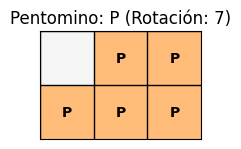

In [22]:
mostrar_pentomino_base('P', rotation_idx=7)


## Solucion 1

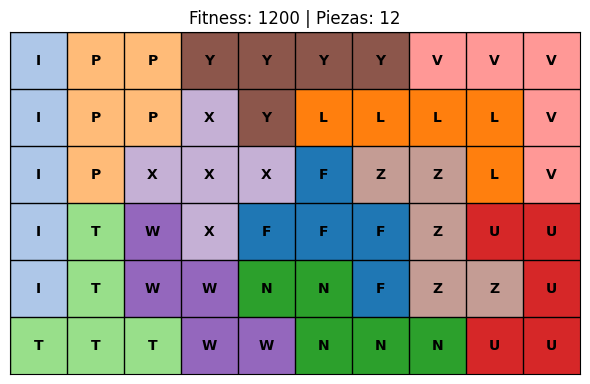

In [23]:
ind = Individuo()
ind.orden = (-2.2,0,1032.2,11,912,-1,-2.4,13000,1.5,80,10,0.01)
ind.rotaciones = (1,0,4,2,0,5,0,0,2,0,3,1)
ind.evaluar(ALTO, ANCHO)
mostrar_individuo(ind)

## Solucion 2

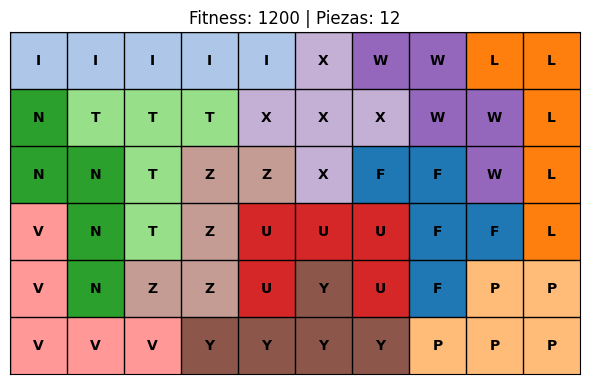

In [24]:
ind = Individuo()
ind.orden = (1,9,8,2,4,5,11,0,7,6,10,3)
ind.rotaciones = (0,0,5,2,4,0,4,7,0,2,6,7)
ind.evaluar(ALTO, ANCHO)
mostrar_individuo(ind)

# Algoritmo Genético (bucle principal)

In [25]:
!pip install deap
from deap import base, creator, tools, algorithms
from scipy.ndimage import label


# Hiperparámetros
ALTO, ANCHO = 6, 10
TAMANO_POBLACION = 500
NGEN = 100
CXPB = 0.8  # Cruce alto
MUTPB = 0.1 # Mutación baja


# 1. CONFIGURACIÓN
if hasattr(creator, "FitnessMin"): del creator.FitnessMin
if hasattr(creator, "Individual"): del creator.Individual

creator.create("FitnessMin", base.Fitness, weights=(-1.0,)) # Minimizar (huecos)
creator.create("Individual", list, fitness=creator.FitnessMin)

toolbox = base.Toolbox()

def crom():
    prioridades = [random.random() for _ in range(12)]
    rotaciones = [random.randint(0, 7) for _ in range(12)]
    return prioridades + rotaciones

toolbox.register("individual", tools.initIterate, creator.Individual, crom)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)


# 2. OPERADORES GENÉTICOS

def cxLinked(ind1, ind2, indpb=0.5):
    """
    Si intercambiamos la pieza i (gen i) intercambiamos tambien su rotación (gen i+12).
    Esto sirve para preservar la relación  de las piezas y sus rotaciones
    """
    size = 12
    for i in range(size):
        if random.random() < indpb:
            # Swap Prioridad
            ind1[i], ind2[i] = ind2[i], ind1[i]
            # Swap Rotación (Vinculando piezas con su rotacion)
            ind1[i+size], ind2[i+size] = ind2[i+size], ind1[i+size]
    return ind1, ind2

def mutMixed(individual, indpb, mu=0, sigma=0.2):
    """ Mutación híbrida: para la pieza i le sumamos un valor pequeño para no desarmar todo el esquema, y para la rotacion se escoge un valor random """
    size = 12
    for i in range(len(individual)):
        if random.random() < indpb:
            if i < size:
                # Mutar Prioridad
                individual[i] += random.gauss(mu, sigma)
            else:
                # Mutar Rotacion
                individual[i] = random.randint(0, 7)
    return individual,

toolbox.register("mate", cxLinked, indpb=0.5)
toolbox.register("mutate", mutMixed, indpb=0.05) # Probabilidad aun mas baja por gen
toolbox.register("select", tools.selTournament, tournsize=3)


# 3. FUNCIÓN OBJETIVO

def contar_islas(grid):
    # Aqui contamos grupos de huecos aislados --> mas islas =peor
    mask = (grid == -1).astype(int) #hacemos un grid en el que hay 1 y 0 para contar los grupos sueltos
    _, num_features = label(mask)
    return num_features

def funcion_objetivo(ind):
    # 1. Separar el cromosoma
    prioridades = ind[:12]
    rotaciones = [int(r) % 8 for r in ind[12:]] # Asegurar 0-7

    # 2. Convertir prioridades float a orden de IDs (0-11)
    # Creamos tuplas (valor_prio, id_pieza) y ordenamos
    ordenados = sorted(enumerate(prioridades), key=lambda x: x[1], reverse=True)
    cromosoma_orden = [x[0] for x in ordenados] # Solo los IDs ordenados

    rotaciones_ordenadas = [rotaciones[pid] for pid in cromosoma_orden]

    # 3. Usamos el decodificador
    grid, piezas, huecos = decodificador_completo(cromosoma_orden, rotaciones_ordenadas, ALTO, ANCHO)

    # Guardamos datos en el individuo para visualizarlos luego
    ind.tablero = grid
    ind.piezas_colocadas = piezas
    ind.huecos = huecos

    # 4. Cálculo de Fitness
    # Base: Huecos (queremos 0)
    score = huecos * 100

    # Penalización por Islas (Huecos dispersos son peores que juntos)
    if huecos > 0:
        islas = contar_islas(grid)
        score += islas * 50

    # Desempate: Si empatan a huecos, preferimos más piezas colocadas
    score -= piezas * 10

    return score,

toolbox.register("evaluate", funcion_objetivo)

Ejecutando AG con 500 individuos y 100 generaciones...
gen	nevals	avg    	min
0  	500   	1753.16	590
1  	417   	1684.08	1000
2  	396   	1613.88	1050
3  	405   	1583.62	640 
4  	379   	1556.22	490 
5  	420   	1549.06	640 
6  	402   	1534.22	590 
7  	412   	1514.3 	540 
8  	397   	1463.94	540 
9  	411   	1464.82	540 
10 	418   	1466.52	540 
11 	409   	1457.42	540 
12 	424   	1442.82	490 
13 	396   	1440   	490 
14 	408   	1414.3 	440 
15 	417   	1414.84	490 
16 	399   	1407.94	490 
17 	432   	1415.3 	490 
18 	411   	1427.44	490 
19 	414   	1395.32	540 
20 	413   	1375.74	540 
21 	425   	1388.34	540 
22 	425   	1393.2 	490 
23 	394   	1354.6 	540 
24 	411   	1348.26	490 
25 	411   	1341.44	540 
26 	419   	1345.02	440 
27 	408   	1333.72	440 
28 	413   	1301.02	440 
29 	396   	1261.6 	440 
30 	409   	1252.88	440 
31 	413   	1261.02	490 
32 	404   	1232.7 	440 
33 	397   	1188.84	440 
34 	413   	1148.9 	440 
35 	396   	1139.9 	490 
36 	435   	1136.5 	440 
37 	404   	1085.88	440 
38 	425   	

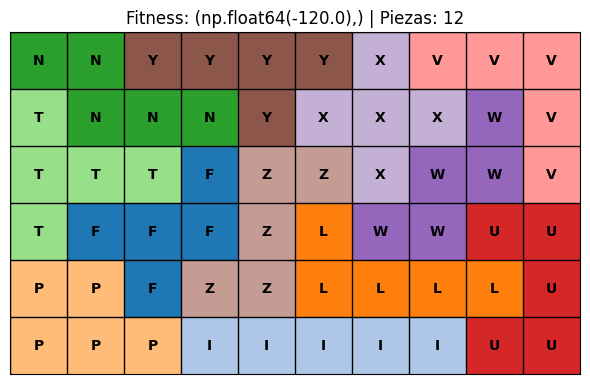

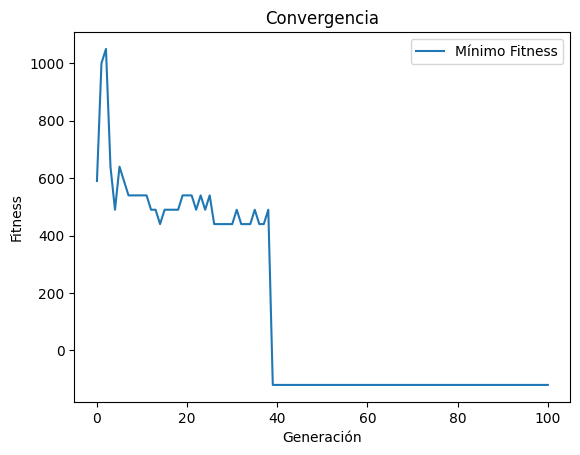

In [26]:
# EJECUCIÓN

def main():
    random.seed(42)
    pop = toolbox.population(n=TAMANO_POBLACION)
    hof = tools.HallOfFame(2)

    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("avg", np.mean)
    stats.register("min", np.min)

    print(f"Ejecutando AG con {TAMANO_POBLACION} individuos y {NGEN} generaciones...")
    pop, log = algorithms.eaSimple(pop, toolbox, cxpb=CXPB, mutpb=MUTPB, ngen=NGEN,
                                   stats=stats, halloffame=hof, verbose=True)

    best = hof[0]
    # última evaluación para llenar los atributos tablero/piezas en el objeto best
    funcion_objetivo(best)

    print(f"\nMEJOR SOLUCIÓN: Fitness {best.fitness.values[0]}")
    mostrar_individuo(best)

    return log

if __name__ == "__main__":
    log = main()

    # Gráfica de convergencia
    gen = log.select("gen")
    fit_min = log.select("min")
    plt.plot(gen, fit_min, label="Mínimo Fitness")
    plt.xlabel("Generación")
    plt.ylabel("Fitness")
    plt.title("Convergencia")
    plt.legend()
    plt.show()
